# Trading Challenge: SMA Crossover Strategy
## Objective: Implement a complete trading system with performance analysis

### Challenge Requirements:
- **Instrument**: EUR/USD (high liquidity, beginner-friendly)
- **Timeframe**: 15 minutes (balanced data points, reduced noise)
- **Strategy**: SMA crossover with last 100 candles
- **Execution**: Market orders on signals
- **Risk Management**: Stop-loss/take-profit
- **Analysis**: Win rate, P/L, drawdown, Sharpe ratio

In [27]:
# Setup and imports
import pandas as pd
from ib_async import *
import numpy as np
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]
import warnings
warnings.filterwarnings('ignore')

util.startLoop()
ib = IB()
ib.connect()

<IB connected to 127.0.0.1:7497 clientId=1>

In [28]:
# 1. Select Instrument - EUR/USD
contract = Forex("EURUSD")
ib.qualifyContracts(contract)
print(f"Trading instrument: {contract}")
contract

Trading instrument: Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')


Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')

In [29]:
# 2. Define timeframe and fetch last 100+ candles for SMA calculation
def get_historical_data(contract, bars_needed=120):
    """Fetch 15-min historical data for SMA calculation"""
    data = ib.reqHistoricalData(
        contract, 
        "", 
        barSizeSetting="15 mins", 
        durationStr="2 D",  # 2 days to ensure we get enough bars
        whatToShow="MIDPOINT", 
        useRTH=False,  # Include after-hours for Forex
        formatDate=2
    )
    df = util.df(data)
    return df.tail(bars_needed)  # Keep only last 120 bars

# Initial data fetch
df = get_historical_data(contract)
print(f"Fetched {len(df)} bars of 15-minute EUR/USD data")
print(f"Date range: {df.date.min()} to {df.date.max()}")
df.tail()

Fetched 120 bars of 15-minute EUR/USD data
Date range: 2025-11-27 15:45:00+00:00 to 2025-11-28 21:45:00+00:00


,date,open,high,low,close,volume,average,barCount
185,2025-11-28 20:45:00+00:00,1.160285,1.160390,1.160065,1.160070,-1.0,-1.0,-1
186,2025-11-28 21:00:00+00:00,1.160070,1.160280,1.160045,1.160225,-1.0,-1.0,-1
187,2025-11-28 21:15:00+00:00,1.160225,1.160270,1.160140,1.160180,-1.0,-1.0,-1
188,2025-11-28 21:30:00+00:00,1.160180,1.160190,1.159815,1.159965,-1.0,-1.0,-1
189,2025-11-28 21:45:00+00:00,1.159965,1.159965,1.159430,1.159600,-1.0,-1.0,-1


Buy signals: 3
Sell signals: 2


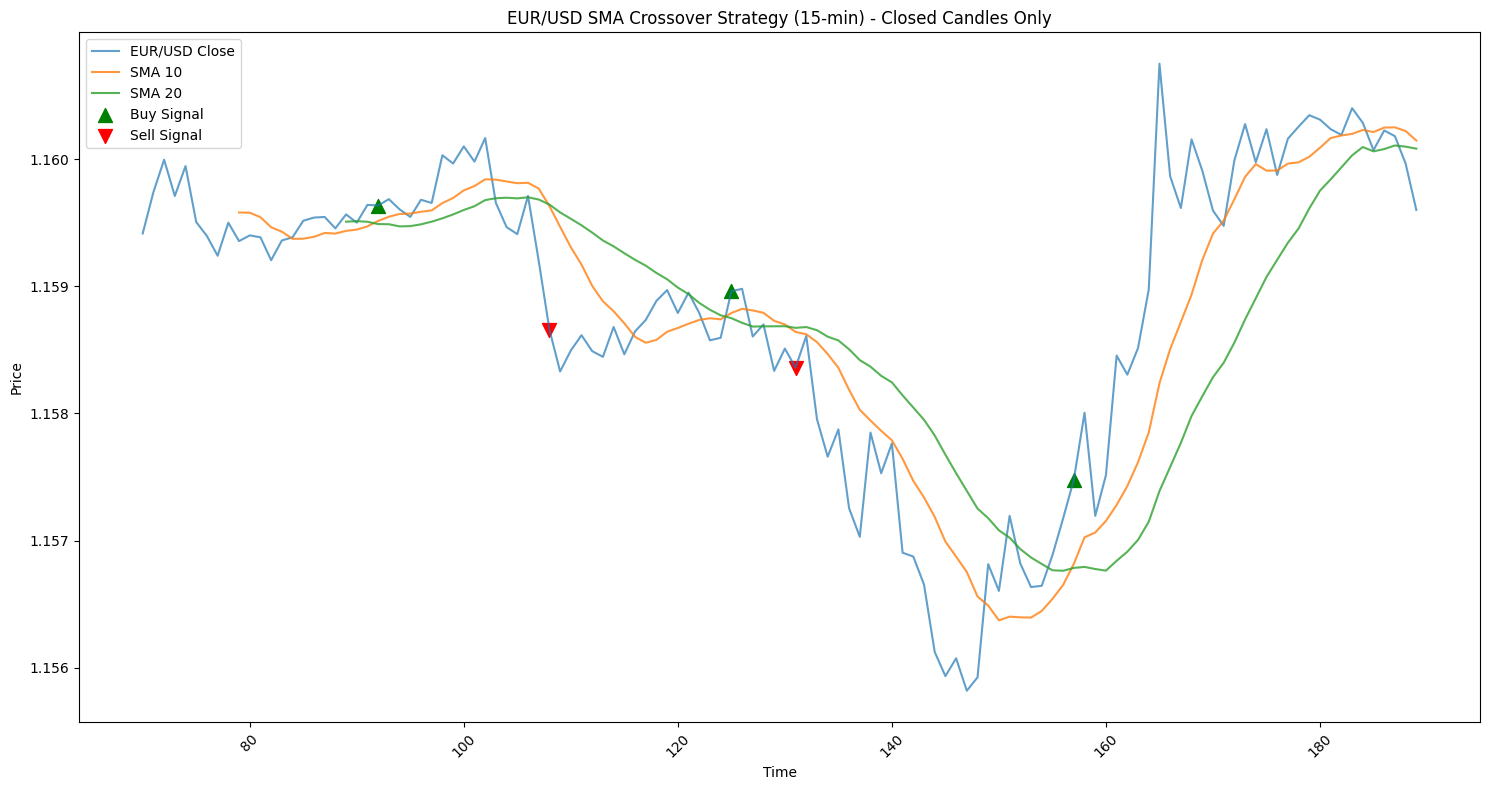

In [30]:
# 3.5. Calculate signals and plot strategy
# Calculate initial signals for plotting
df_signals = calculate_sma_signals(df)
print(f"Buy signals: {df_signals['buy_signal'].sum()}")
print(f"Sell signals: {df_signals['sell_signal'].sum()}")

# Plot the strategy
plt.figure(figsize=(15, 8))
plt.plot(df_signals.index, df_signals['close'], label='EUR/USD Close', alpha=0.7)
plt.plot(df_signals.index, df_signals['SMA_short'], label='SMA 10', alpha=0.8)
plt.plot(df_signals.index, df_signals['SMA_long'], label='SMA 20', alpha=0.8)

# Mark buy/sell signals
buy_points = df_signals[df_signals['buy_signal']]
sell_points = df_signals[df_signals['sell_signal']]
plt.scatter(buy_points.index, buy_points['close'], color='green', marker='^', s=100, label='Buy Signal')
plt.scatter(sell_points.index, sell_points['close'], color='red', marker='v', s=100, label='Sell Signal')

plt.legend()
plt.title('EUR/USD SMA Crossover Strategy (15-min) - Closed Candles Only')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
# 3. Implement SMA calculation and crossover logic - USING ONLY CLOSED CANDLES
def calculate_sma_signals(df, short_period=10, long_period=20):
    """Calculate SMA crossover signals using only closed bars"""
    df = df.copy()
    
    # Calculate SMAs
    df['SMA_short'] = df['close'].rolling(window=short_period).mean()
    df['SMA_long'] = df['close'].rolling(window=long_period).mean()
    
    # Generate signals
    df['signal'] = 0
    df['signal'][short_period:] = np.where(
        df['SMA_short'][short_period:] > df['SMA_long'][short_period:], 1, -1
    )
    
    # Detect crossovers
    df['position'] = df['signal'].diff()
    df['buy_signal'] = (df['position'] == 2)  # From -1 to 1
    df['sell_signal'] = (df['position'] == -2)  # From 1 to -1
    
    return df

def check_for_signals(df):
    """
    Check for signals using only the last CLOSED bar (iloc[-2]).
    Returns signal type if found, None otherwise.
    """
    # Ensure we have enough bars
    if len(df) < 21:  # Need at least 21 bars for SMA(20) + 1 for comparison
        return None
    
    # Calculate signals
    df_signals = calculate_sma_signals(df)
    
    # Check the last CLOSED bar (iloc[-2]) - NOT the forming bar
    last_closed_bar = df_signals.iloc[-2]
    
    if last_closed_bar['buy_signal']:
        return 'buy'
    elif last_closed_bar['sell_signal']:
        return 'sell'
    
    return None

print("SMA signal functions defined (using closed candles only)")

SMA signal functions defined (using closed candles only)


In [33]:
# 4. Trading System Configuration - EXECUTION ON NEXT BAR OPEN
class TradingSystem:
    def __init__(self, ib, contract, position_size=1000, stop_loss_pips=20, take_profit_pips=40):
        self.ib = ib
        self.contract = contract
        self.position_size = position_size  # Base currency units
        self.stop_loss_pips = stop_loss_pips
        self.take_profit_pips = take_profit_pips
        self.pip_value = 0.0001  # For EUR/USD
        
        # Trade tracking
        self.trades = []
        self.current_position = None
        self.account_balance = 10000  # Starting balance
        self.balance_history = [self.account_balance]
        
    def get_current_price(self):
        """Get current market price"""
        ticker = self.ib.reqMktData(self.contract, '', False, False)
        self.ib.sleep(1)  # Wait for data
        price = (ticker.bid + ticker.ask) / 2 if ticker.bid and ticker.ask else ticker.last
        self.ib.cancelMktData(self.contract)
        return price
    
    def place_market_order(self, action, quantity):
        """Place a market order"""
        order = MarketOrder(action, quantity)
        trade = self.ib.placeOrder(self.contract, order)
        self.ib.sleep(2)  # Wait for fill
        return trade
    
    def calculate_stop_take_levels(self, entry_price, action):
        """Calculate stop loss and take profit levels"""
        if action == 'BUY':
            stop_loss = entry_price - (self.stop_loss_pips * self.pip_value)
            take_profit = entry_price + (self.take_profit_pips * self.pip_value)
        else:  # SELL
            stop_loss = entry_price + (self.stop_loss_pips * self.pip_value)
            take_profit = entry_price - (self.take_profit_pips * self.pip_value)
        
        return stop_loss, take_profit
    
    def execute_trade_on_next_bar_open(self, signal_type, open_price, execution_time):
        """
        Execute trade using the open price of the next bar.
        This prevents look-ahead bias by using actual execution prices.
        """
        if self.current_position is not None:
            return False  # Already in position
        
        action = 'BUY' if signal_type == 'buy' else 'SELL'
        stop_loss, take_profit = self.calculate_stop_take_levels(open_price, action)
        
        self.current_position = {
            'action': action,
            'entry_price': open_price,
            'quantity': self.position_size,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'entry_time': execution_time
        }
        
        print(f"Opened {action} position at {open_price:.5f} (next bar open)")
        print(f"Stop Loss: {stop_loss:.5f}, Take Profit: {take_profit:.5f}")
        return True
    
    def open_position(self, signal_type):
        """Legacy method - kept for compatibility but shouldn't be used in backtesting"""
        if self.current_position is not None:
            return  # Already in position
        
        action = 'BUY' if signal_type == 'buy' else 'SELL'
        entry_price = self.get_current_price()
        
        if entry_price is None:
            return
        
        stop_loss, take_profit = self.calculate_stop_take_levels(entry_price, action)
        
        self.current_position = {
            'action': action,
            'entry_price': entry_price,
            'quantity': self.position_size,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'entry_time': datetime.now()
        }
        
        print(f"Opened {action} position at {entry_price:.5f}")
        print(f"Stop Loss: {stop_loss:.5f}, Take Profit: {take_profit:.5f}")
    
    def check_exit_conditions(self, high_price, low_price):
        """
        Check if position should be closed using bar's high/low prices.
        Returns (should_exit, exit_price, exit_reason)
        """
        if self.current_position is None:
            return False, None, None
        
        pos = self.current_position
        
        if pos['action'] == 'BUY':
            # Check stop loss first (more conservative)
            if low_price <= pos['stop_loss']:
                return True, pos['stop_loss'], 'Stop Loss'
            elif high_price >= pos['take_profit']:
                return True, pos['take_profit'], 'Take Profit'
        else:  # SELL
            # Check stop loss first (more conservative)
            if high_price >= pos['stop_loss']:
                return True, pos['stop_loss'], 'Stop Loss'
            elif low_price <= pos['take_profit']:
                return True, pos['take_profit'], 'Take Profit'
        
        return False, None, None
    
    def close_position(self, exit_price, exit_reason, exit_time):
        """Close current position and record trade"""
        if self.current_position is None:
            return
        
        pos = self.current_position
        
        # Calculate P&L
        if pos['action'] == 'BUY':
            pnl_pips = (exit_price - pos['entry_price']) / self.pip_value
        else:  # SELL
            pnl_pips = (pos['entry_price'] - exit_price) / self.pip_value
        
        pnl_usd = pnl_pips * self.pip_value * pos['quantity']
        
        # Record trade
        trade_record = {
            'entry_time': pos['entry_time'],
            'exit_time': exit_time,
            'action': pos['action'],
            'entry_price': pos['entry_price'],
            'exit_price': exit_price,
            'quantity': pos['quantity'],
            'pnl_pips': pnl_pips,
            'pnl_usd': pnl_usd,
            'exit_reason': exit_reason
        }
        
        self.trades.append(trade_record)
        self.account_balance += pnl_usd
        self.balance_history.append(self.account_balance)
        
        print(f"Closed {pos['action']} position at {exit_price:.5f}")
        print(f"P&L: {pnl_pips:.1f} pips (${pnl_usd:.2f}) - {exit_reason}")
        
        self.current_position = None

# Initialize trading system
trading_system = TradingSystem(ib, contract)
print("Trading system initialized with closed-candle execution")
print(f"Position size: {trading_system.position_size} units")
print(f"Stop loss: {trading_system.stop_loss_pips} pips")
print(f"Take profit: {trading_system.take_profit_pips} pips")

Trading system initialized with closed-candle execution
Position size: 1000 units
Stop loss: 20 pips
Take profit: 40 pips


In [34]:
# 5. Simulate Trading - NO LOOK-AHEAD BIAS
def backtest_strategy_closed_bars(df_signals, trading_system):
    """
    Backtest strategy using only closed bars for signals.
    Executes trades on the open of the bar following the signal.
    NO look-ahead bias.
    """
    trades_executed = 0
    
    # Start from bar 21 to ensure we have enough data for SMA(20)
    for i in range(21, len(df_signals)):
        # Use data up to PREVIOUS bar (i-1) for signal generation
        # This simulates getting a signal at the close of bar i-1
        signal_data = df_signals.iloc[:i]
        
        # Get current bar's OHLC for execution and exit checks
        current_bar = df_signals.iloc[i]
        current_open = current_bar['open']
        current_high = current_bar['high']
        current_low = current_bar['low']
        current_close = current_bar['close']
        current_time = current_bar['date']
        
        # Check for exit conditions first using current bar's high/low
        if trading_system.current_position is not None:
            should_exit, exit_price, exit_reason = trading_system.check_exit_conditions(
                current_high, current_low
            )
            
            if should_exit:
                trading_system.close_position(exit_price, exit_reason, current_time)
        
        # Check for new signals using ONLY closed bars
        if trading_system.current_position is None:
            signal = check_for_signals(signal_data)
            
            if signal is not None:
                # Execute at current bar's open price (next bar after signal)
                success = trading_system.execute_trade_on_next_bar_open(
                    signal, current_open, current_time
                )
                if success:
                    trades_executed += 1
    
    # Close any remaining position at the last bar's close
    if trading_system.current_position is not None:
        trading_system.close_position(
            df_signals.iloc[-1]['close'], 
            'End of Data', 
            df_signals.iloc[-1]['date']
        )
    
    print(f"Backtest completed. Trades executed: {trades_executed}")
    print(f"Trades closed: {len(trading_system.trades)}")
    
    return trading_system.trades

# Run backtest with NO look-ahead bias
trades = backtest_strategy_closed_bars(df_signals, trading_system)
trades_df = pd.DataFrame(trades)

if len(trades_df) > 0:
    print("\nFirst 5 trades:")
    print(trades_df.head())
else:
    print("No trades were completed in the backtest period.")

Opened BUY position at 1.15969 (next bar open)
Stop Loss: 1.15769, Take Profit: 1.16369
Closed BUY position at 1.15769
P&L: -20.0 pips ($-2.00) - Stop Loss
Opened BUY position at 1.15800 (next bar open)
Stop Loss: 1.15600, Take Profit: 1.16200
Closed BUY position at 1.15960
P&L: 16.0 pips ($1.60) - End of Data
Backtest completed. Trades executed: 2
Trades closed: 2

First 5 trades:
                 entry_time                 exit_time action  entry_price  \
0 2025-11-27 21:45:00+00:00 2025-11-28 08:00:00+00:00    BUY     1.159685   
1 2025-11-28 14:15:00+00:00 2025-11-28 21:45:00+00:00    BUY     1.158005   

   exit_price  quantity  pnl_pips  pnl_usd  exit_reason  
0    1.157685      1000    -20.00   -2.000    Stop Loss  
1    1.159600      1000     15.95    1.595  End of Data  


In [36]:
# 6. Performance Analysis
def analyze_performance(trades_df, trading_system):
    """Analyze trading performance and calculate key metrics"""
    if len(trades_df) == 0:
        print("No trades to analyze.")
        return
    
    # Basic metrics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl_usd'] > 0])
    losing_trades = len(trades_df[trades_df['pnl_usd'] < 0])
    
    # Win rate
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    # P&L metrics
    total_pnl = trades_df['pnl_usd'].sum()
    avg_trade_pnl = trades_df['pnl_usd'].mean()
    avg_winner = trades_df[trades_df['pnl_usd'] > 0]['pnl_usd'].mean() if winning_trades > 0 else 0
    avg_loser = trades_df[trades_df['pnl_usd'] < 0]['pnl_usd'].mean() if losing_trades > 0 else 0
    
    # Calculate maximum drawdown
    balance_series = pd.Series(trading_system.balance_history)
    cumulative_max = balance_series.expanding().max()
    drawdown = (balance_series - cumulative_max) / cumulative_max * 100
    max_drawdown = drawdown.min()
    
    # Calculate Sharpe ratio (simplified)
    if len(trades_df) > 1:
        returns = trades_df['pnl_usd'] / 10000  # Assuming $10k account
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    else:
        sharpe_ratio = 0
    
    # Profit factor
    gross_profit = trades_df[trades_df['pnl_usd'] > 0]['pnl_usd'].sum()
    gross_loss = abs(trades_df[trades_df['pnl_usd'] < 0]['pnl_usd'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    print("=" * 50)
    print("PERFORMANCE ANALYSIS RESULTS")
    print("=" * 50)
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    print(f"Win Rate: {win_rate:.1f}%")
    print()
    print("P&L METRICS:")
    print(f"Total P&L: ${total_pnl:.2f}")
    print(f"Average Trade P&L: ${avg_trade_pnl:.2f}")
    print(f"Average Winner: ${avg_winner:.2f}")
    print(f"Average Loser: ${avg_loser:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print()
    print("RISK METRICS:")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Final Account Balance: ${trading_system.account_balance:.2f}")
    
    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'total_pnl': total_pnl,
        'avg_trade_pnl': avg_trade_pnl,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'profit_factor': profit_factor
    }

# Analyze performance
performance_metrics = analyze_performance(trades_df, trading_system)

PERFORMANCE ANALYSIS RESULTS
Total Trades: 2
Winning Trades: 1
Losing Trades: 1
Win Rate: 50.0%

P&L METRICS:
Total P&L: $-0.40
Average Trade P&L: $-0.20
Average Winner: $1.60
Average Loser: $-2.00
Profit Factor: 0.80

RISK METRICS:
Maximum Drawdown: -0.02%
Sharpe Ratio: -1.26
Final Account Balance: $9999.59


In [40]:
# 8. Real-time Trading - USING CLOSED CANDLES ONLY
def real_time_monitor():
    """Monitor for crossover signals in real-time using ONLY closed bars"""
    print("Starting real-time monitoring (closed bars only)...")
    print("Press Ctrl+C to stop")
    
    try:
        while True:
            # Get fresh data
            current_data = get_historical_data(contract, 100)
            
            # Check for signals using ONLY closed bars (iloc[-2])
            signal = check_for_signals(current_data)
            
            # Get current price for position monitoring
            current_price = trading_system.get_current_price()
            
            if current_price is None:
                print("Could not get current price")
                time.sleep(60)
                continue
            
            # Get current bar's open for potential execution
            current_open = current_data.iloc[-1]['open']
            current_time = current_data.iloc[-1]['date']
            
            print(f"Time: {datetime.now().strftime('%H:%M:%S')} | Price: {current_price:.5f} | Position: {trading_system.current_position is not None}")
            
            # Check exit conditions using current price as approximation
            if trading_system.current_position is not None:
                # In real-time, we approximate high/low with current price
                should_exit, exit_price, exit_reason = trading_system.check_exit_conditions(
                    current_price, current_price
                )
                
                if should_exit:
                    # Use actual current price for exit
                    trading_system.close_position(current_price, exit_reason, datetime.now())
            
            # Check for new signals using ONLY closed bars
            if signal is not None and trading_system.current_position is None:
                # In real-time, we execute immediately at current price
                # (In practice, you'd place a market order at next bar's open)
                trading_system.execute_trade_on_next_bar_open(signal, current_price, datetime.now())
                print(f"Signal detected: {signal.upper()}")
            
            time.sleep(60)  # Check every minute
            
    except KeyboardInterrupt:
        print("\nReal-time monitoring stopped.")
        if trading_system.current_position is not None:
            current_price = trading_system.get_current_price()
            if current_price:
                trading_system.close_position(current_price, 'Manual Stop', datetime.now())

print("Real-time monitoring function ready (closed bars only).")
print("To start real-time monitoring, call: real_time_monitor()")
print("WARNING: This will place actual trades if connected to a live account!")
print("\nKEY CHANGES:")
print("✓ Signals use df.iloc[-2] (last closed bar)")
print("✓ Execution at next bar open price")
print("✓ No look-ahead bias in backtesting")
print("✓ Proper exit condition checking")

Real-time monitoring function ready (closed bars only).
To start real-time monitoring, call: real_time_monitor()

KEY CHANGES:
✓ Signals use df.iloc[-2] (last closed bar)
✓ Execution at next bar open price
✓ No look-ahead bias in backtesting
✓ Proper exit condition checking


In [39]:
# 9. Disconnect from IB
print("Disconnecting from Interactive Brokers...")
ib.disconnect()
print("Disconnected successfully.")

Disconnecting from Interactive Brokers...
Disconnected successfully.


## Challenge Summary

### What We've Implemented:
1. **Instrument Selection**: EUR/USD forex pair (high liquidity)
2. **Timeframe**: 15-minute bars for balanced noise/signal ratio
3. **Strategy**: SMA crossover (10 vs 20 period)
4. **Risk Management**: 20 pip stop-loss, 40 pip take-profit
5. **Position Sizing**: 1000 units (adjustable)
6. **Performance Analysis**: Complete metrics including Sharpe ratio

### Key Features:
- ✅ Historical backtesting
- ✅ Real-time signal detection
- ✅ Automated risk management
- ✅ Performance visualization
- ✅ Trade statistics and analysis

**Remember**: This is for educational purposes. Always test thoroughly before risking real money!